# Assignment #1: PFL067 Statistical NLP

## Exploring Entropy and Language Modeling

### Author: Dan Kondratyuk

### November 8, 2017

---

This Python notebook examines conditional entropy as it relates to bigram language models and cross entropy as it relates to linear interpolation smoothing.

### 1. Entropy of a Text

#### Problem Statement
> In this experiment, you will determine the conditional entropy of the word distribution in a text given the previous word. To do this, you will first have to compute P(i,j), which is the probability that at any position in the text you will find the word i followed immediately by the word j, and P(j|i), which is the probability that if word i occurs in the text then word j will follow. Given these probabilities, the conditional entropy of the word distribution in a text given the previous word can then be computed as:

> $$H(J|I) = -\sum_{i \in I, j \in J} P(i,j) \log_2 P(j|i)$$

> The perplexity is then computed simply as

> $$P_X(P(J|I)) = 2^{H(J|I)}$$

> Compute this conditional entropy and perplexity for `TEXTEN1.txt`. This file has every word on a separate line. (Punctuation is considered a word, as in many other cases.) The i,j above will also span sentence boundaries, where i is the last word of one sentence and j is the first word of the following sentence (but obviously, there will be a fullstop at the end of most sentences).

> Next, you will mess up the text and measure how this alters the conditional entropy. For every character in the text, mess it up with a likelihood of 10%. If a character is chosen to be messed up, map it into a randomly chosen character from the set of characters that appear in the text. Since there is some randomness to the outcome of the experiment, run the experiment 10 times, each time measuring the conditional entropy of the resulting text, and give the min, max, and average entropy from these experiments. Be sure to use srand to reset the random number generator seed each time you run it. Also, be sure each time you are messing up the original text, and not a previously messed up text. Do the same experiment for mess up likelihoods of 5%, 1%, .1%, .01%, and .001%.

> Next, for every word in the text, mess it up with a likelihood of 10%. If a word is chosen to be messed up, map it into a randomly chosen word from the set of words that appear in the text. Again run the experiment 10 times, each time measuring the conditional entropy of the resulting text, and give the min, max, and average entropy from these experiments. Do the same experiment for mess up likelihoods of 5%, 1%, .1%, .01%, and .001%.

> Now do exactly the same for the file `TEXTCZ1.txt`, which contains a similar amount of text in an unknown language (just FYI, that's Czech*)

> Tabulate, graph and explain your results. Also try to explain the differences between the two languages. To substantiate your explanations, you might want to tabulate also the basic characteristics of the two texts, such as the word count, number of characters (total, per word), the frequency of the most frequent words, the number of words with frequency 1, etc.

### Process Text
The first step is to define functions to calculate probabilites of bigrams/unigrams and conditional entropy of a text. This can be done by counting up the frequency of bigrams and unigrams. The `BigramModel` class contains all the necessary functionality to compute the entropy of a text. By counting up the word unigram/bigram frequencies, we can divide the necessary counts to get the appropriate probabilities for the entropy function.

In [1]:
# Import Python packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections as c
from collections import defaultdict

# Configure Plots
plt.rcParams['lines.linewidth'] = 4

In [2]:
np.random.seed(200) # Set a seed so that this notebook has the same output each time

In [3]:
def open_text(filename):
    """Reads a text line by line, applies light preprocessing, and returns an array of words"""
    with open(filename, encoding='iso-8859-2') as f:
        content = f.readlines()
    
    preprocess = lambda word: word.strip()
    
    return np.array([preprocess(word) for word in content])

In [4]:
class BigramModel:
    """Counts up bigrams and calculates probabilities"""
    
    def __init__(self, words):
        self.words = words
        self.word_set = list(set(words))
        self.word_count = len(self.word_set)
        self.total_word_count = len(self.words)
        self.unigram_dist = c.Counter(words)
        
        self.bigrams = list(nltk.bigrams(words))
        self.bigram_set = list(set(self.bigrams))
        self.bigram_count = len(self.bigram_set)
        self.total_bigram_count = len(self.bigrams)
        self.dist = c.Counter(self.bigrams)
    
    def p_bigram(self, wprev, w):
        """Calculates the probability a bigram appears in the distribution"""
        return self.dist[(wprev, w)] / self.total_bigram_count

    def p_bigram_cond(self, wprev, w):
        """Calculates the probability a word appears in the distribution given the previous word"""
        return self.dist[(wprev, w)] / self.unigram_dist[wprev]
    
    def entropy_cond(self):
        """Calculates the conditional entropy from a list of bigrams"""
        bigram_set = self.bigram_set
        return - np.sum(self.p_bigram(*bigram) * 
                        np.log2(self.p_bigram_cond(*bigram)) 
                        for bigram in bigram_set)

    def perplexity_cond(self, entropy=-1):
        """Calculates the conditional perplexity from the given conditional entropy"""
        if (entropy < 0):
            return 2 ** self.entropy_cond()
        else:
            return 2 ** entropy

### Perturb Texts
Define functions to process a list of words and, with a given probability, alter each character/word to a random character/word.

In [5]:
def charset(words):
    """Given a list of words, calculates the set of characters over all words"""
    return np.array(list(set(char for word in words for char in word)))

In [6]:
def vocab_list(words):
    """Given a list of words, calculates the vocabulary (word set)"""
    return np.array(list(set(word for word in words)))

In [7]:
def perturb_char(word, charset, prob=0.1):
    """Changes each character with given probability to a random character in the charset"""
    return ''.join(np.random.choice(charset) if np.random.random() < prob else char for char in word)

In [8]:
def perturb_word(word, vocabulary, prob=0.1):
    """Changes a word with given probability to a random word in the vocabulary"""
    return np.random.choice(vocabulary) if np.random.random() < prob else word

In [9]:
def perturb_text(words, seed=200):
    """Given a list of words, perturbs each word both on the character level 
    and the word level. Does this for a predefined list of probabilties"""
    np.random.seed(seed)
    
    chars = charset(words)
    vocab = vocab_list(words)
    text_chars, text_words = pd.DataFrame(), pd.DataFrame()
    probabilities = [0, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]
    
    for prob in probabilities:
        text_chars[str(prob)] = [perturb_char(word, chars,    prob=prob) for word in words]
        text_words[str(prob)] = [perturb_word(word, vocab, prob=prob) for word in words]
    
    return text_chars, text_words

### Gather Statistics
The following functions perturb a given text on the character and word level by a defined list of probabilities and compute statistical information for each probability data point.

In [73]:
def text_stats(words):
    """Given a list of words, this calculates various statistical 
    properties like entropy, number of characters, etc."""
    bigram_model = BigramModel(words)
    
    entropy = bigram_model.entropy_cond()
    perplexity = bigram_model.perplexity_cond(entropy=entropy)
    vocab_size = bigram_model.word_count
    char_count = len([char for word in words for char in word])
    chars_per_word = char_count / len(words)
    words_freq_1 = sum(1 for key in bigram_model.unigram_dist if bigram_model.unigram_dist[key] == 1)

    return [entropy, perplexity, vocab_size, char_count, chars_per_word, words_freq_1]

In [74]:
def run_stats(words, seed=200):
    """Calculates statistics for one run of perturbed probabilities of a given text 
    and outputs them to two tables (character and word level respectively)"""

    perturbed_text = perturb_text(words, seed=seed)
    text_chars, text_words = perturbed_text
    
    col_names = [
        'prob', 'entropy', 'perplexity', 'vocab_size', 'char_count', 
        'chars_per_word', 'words_freq_1'
    ]
    
    char_stats = pd.DataFrame(columns=col_names)
    word_stats = pd.DataFrame(columns=col_names)
    
    # Iterate through all perturbation probabilities and gather statistics
    for col in text_chars:
        char_stats_calc = text_stats(list(text_chars[col]))
        char_stats.loc[len(char_stats)] = [float(col)] + char_stats_calc
        
        word_stats_calc = text_stats(list(text_words[col]))
        word_stats.loc[len(word_stats)] = [float(col)] + word_stats_calc
   
    return char_stats, word_stats

In [79]:
def all_stats(words, num_runs=10):
    """Calculates statistics for all runs of perturbed probabilities of a given text 
    and outputs the averaged values to two tables (character and word level respectively)"""
    
    char_runs, word_runs = zip(*[run_stats(words, seed=i) for i in range(num_runs)])
    
    char_concat, word_concat = pd.concat(char_runs), pd.concat(word_runs)
    
    char_avg = char_concat.groupby(char_concat.index).mean()
    word_avg = word_concat.groupby(word_concat.index).mean()
    
    return char_avg, word_avg

In [80]:
def create_cond_entropy_plot(label, word_stats, char_stats):
    """Plots the word and character entropy of the given text statistics"""
    plt.plot(word_stats.prob, word_stats.entropy, label='Word Entropy')
    plt.plot(char_stats.prob, char_stats.entropy, label='Character Entropy')
    plt.suptitle('Entropy (' + label + ')')
    plt.xlabel('Probability')
    plt.ylabel('Entropy')
    _ = plt.legend()

### Results (part 1): Calculate, Tabulate, and Graph Statistics
Finally, we calculate the conditional entropy of both English and Czech texts, along with their perturbed counterparts as specified in the problem statement. Some additional statistics are calculated to better explain results. Explanations and conclusions of results are given at the end of this section.

In [81]:
# Read the texts into memory
english = './TEXTEN1.txt'
czech = './TEXTCZ1.txt'

words_en = open_text(english)
words_cz = open_text(czech)

In [84]:
# Calculate statistics on all data points
char_stats_en, word_stats_en = all_stats(words_en)
char_stats_cz, word_stats_cz = all_stats(words_cz)

#### English Character Statistics
The table below displays the conditional entropy of the English text when each character can be pertubed with the given probability. The entropy of the English text starts at 5.28 and decreases steadily to 4.7 as more characters are changed randomly. The vocabulary size and number of words with frequency 1 increase substantially.

In [85]:
char_stats_en

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1
0,0.00000,5.287452,39.055456,9607.0,972917.0,4.400388,3811.0
1,0.00001,5.287421,39.054600,9616.8,972917.0,4.400388,3821.2
2,0.00010,5.287174,39.047919,9698.6,972917.0,4.400388,3904.8
3,0.00100,5.283481,38.948114,10505.9,972917.0,4.400388,4718.1
4,0.01000,5.250229,38.060673,17713.2,972917.0,4.400388,11633.8
5,0.05000,5.054971,33.242881,42211.0,972917.0,4.400388,34409.5
6,0.10000,4.731919,26.573634,64346.2,972917.0,4.400388,55099.3


#### English Word Statistics
The table below displays the conditional entropy of the English text when each word can be pertubed with the given probability. The entropy of the English text starts at 5.28 and increases slightly to 5.45 as more words are changed randomly. The vocabulary size decreases very slightly and the number of words with frequency 1 decrease substantially.

In [86]:
word_stats_en

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1
0,0.00000,5.287452,39.055456,9607.0,972917.0,4.400388,3811.0
1,0.00001,5.287475,39.056062,9607.0,972927.3,4.400435,3810.5
2,0.00010,5.287660,39.061074,9606.7,972969.6,4.400626,3803.7
3,0.00100,5.289555,39.112418,9603.1,973597.3,4.403465,3725.9
4,0.01000,5.307040,39.589337,9578.3,979616.2,4.430688,3030.1
5,0.05000,5.379263,41.621703,9546.2,1006275.9,4.551266,1245.4
6,0.10000,5.457192,43.931829,9568.1,1040306.7,4.705184,452.8


#### Czech Character Statistics
The table below displays the conditional entropy of the Czech text when each character can be pertubed with the given probability. The entropy of the Czech text starts at 4.74 and decreases steadily to 4.0 as more characters are changed randomly. The vocabulary size and number of words with frequency 1 increase substantially.

In [87]:
char_stats_cz

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1
0,0.00000,4.747848,26.868573,42826.0,1030631.0,4.633882,26315.0
1,0.00001,4.747733,26.866437,42833.5,1030631.0,4.633882,26323.0
2,0.00010,4.747013,26.853029,42896.8,1030631.0,4.633882,26393.4
3,0.00100,4.738291,26.691175,43597.0,1030631.0,4.633882,27175.7
4,0.01000,4.659041,25.264531,49993.8,1030631.0,4.633882,34341.0
5,0.05000,4.337545,20.217698,73486.6,1030631.0,4.633882,60603.7
6,0.10000,4.004364,16.048517,94487.6,1030631.0,4.633882,84042.4


#### Czech Word Statistics
The table below displays the conditional entropy of the Czech text when each word can be pertubed with the given probability. The entropy of the Czech text starts at 4.74 and decreases slightly to 4.63 as more words are changed randomly. The vocabulary size decreases very slightly and the number of words with frequency 1 decrease as well.

In [88]:
word_stats_cz

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1
0,0.00000,4.747848,26.868573,42826.0,1030631.0,4.633882,26315.0
1,0.00001,4.747834,26.868317,42825.8,1030642.3,4.633933,26313.7
2,0.00010,4.747734,26.866451,42823.8,1030711.5,4.634244,26301.4
3,0.00100,4.747331,26.858941,42798.6,1031253.4,4.636681,26164.6
4,0.01000,4.739277,26.709421,42580.9,1037396.5,4.664301,24876.1
5,0.05000,4.698678,25.968299,41783.7,1065011.3,4.788462,20039.9
6,0.10000,4.637295,24.886609,41235.4,1099100.4,4.941732,15716.5


#### English Plot
The graph below plots the conditional entropy of the English text as a function of the probability of perturbing it. The blue line plots the entropy of the text with perturbed words, and the orange line plots the entropy of the text with purturbed characters.

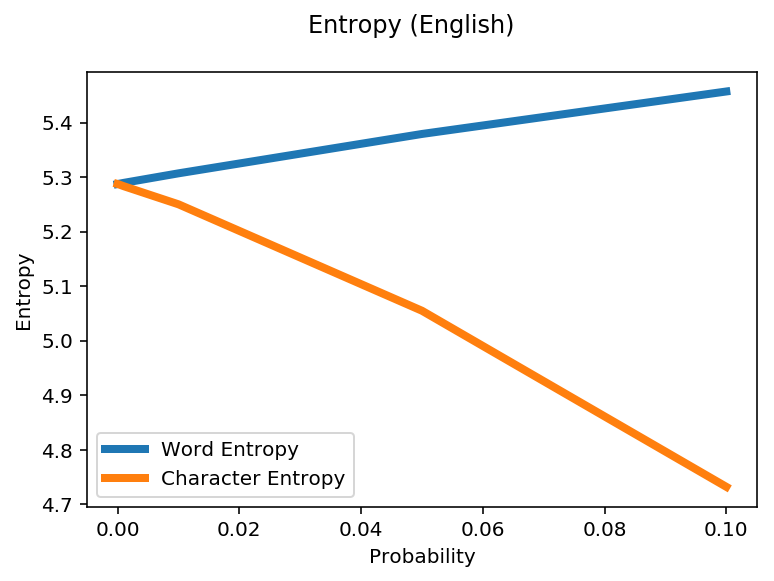

In [89]:
create_cond_entropy_plot('English', word_stats_en, char_stats_en)

The plot shows that the conditional entropy drops as more characters in the words of the text are changed. Looking back at the table, not only does the vocabulary increase substantially, but the number of words with frequency 1 rise as well. Changing a character to a random symbol will more often than not create a new word. Conditional entropy can be thought of as the average amount of information needed to find the next word given its previous word. If the frequency of the previous word is 1, then the next word can be determined entirely from the previous, so no new information is necessary. In other words,

$$p(w_1,w_2) \log_2 p(w_2|w_1) = p(w_1,w_2) \log_2 \frac{c(w_1,w_2)}{c(w_1)} = p(w_1,w_2) \log_2 1 = 0$$

where $(w_1,w_2)$ is a bigram and $c(w_1) = 1$. Therefore, as repeated words are changed to single frequency words, the conditional entropy would go down, as seen in the graph.

The plot also shows that the conditional entropy rises slightly as words in the text are altered to random words in the vocabulary. The table shows that the number of words with frequency 1 decrease rapidly. As no new words can be created, the the chance that a single frequency word will be mapped to a multiple frequency word increases with the probability. This has the effect of increasing the conditional entropy, since more information is necessary to determine the next word given the previous multiple frequency word. In other words, $- p(w_1,w_2) \log_2 p(w_2|w_1) > 0$ for $c(w_1) > 1$.

#### Czech Plot

The graph below plots the conditional entropy of the Czech text as a function of the probability of perturbing it. The blue line plots the entropy of the text with perturbed words, and the orange line plots the entropy of the text with purturbed characters.

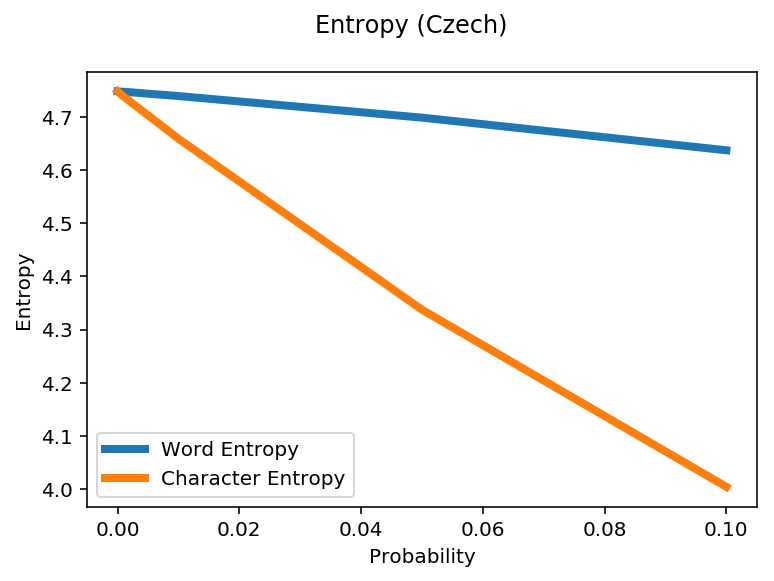

In [90]:
create_cond_entropy_plot('Czech', word_stats_cz, char_stats_cz)

The first thing to notice is that the Czech language has an inherently lower conditional entropy than English (at least for this text). This can be explained by the fact that the Czech text contains many more words with a frequency of 1. As opposed to English, Czech has many more word forms due to its declension and conjucation of words, further increasing its vocabulary size and making it much less likely that words of the same inflection appear in the text. As explained earlier, single frequency words have the effect of decreasing conditional entropy.

Very similar to the English plot, the conditional entropy drops as as more characters in the words of the text are changed. This is due to the same reasons as explained above: the number of words of frequency 1 increase, lowering the amount of information needed to determine the next word given the previous.

Somewhat unexpectedly, the Czech plot shows that the conditional entropy decreases as words in the text are altered to random words in the vocabulary. The English plot shows the opposite effect. Czech is known to be a [free word order](https://en.wikipedia.org/wiki/Czech_word_order) language, which means that (in many cases) words are free to move around the sentence without changing its syntactic structure. What this means is that determining the next word is harder, as other words can be mixed in without changing overall meaning. This requires more information overall (but this is offset to English by the relative vocabulary size). However, as words are altered randomly the chance that the same next word appears increases, futher decreasing entropy.

Since English is highly dependent on word order (making it easy to determine what the next word is), it would make sense that randomly altering words would make it harder to determine what the next word is. It is important to keep in mind that even in the English case, after altering words past a certain point, the entropy should begin to decrease again. This is because low frequency words followed by high frequency words that keep the entropy high will decrease to an equilibrium point where every bigram is equally likely.

#### Problem Statement
> Now assume two languages, $L_1$ and $L_2$ do not share any vocabulary items, and that the conditional entropy as described above of a text $T_1$ in language $L_1$ is $E$ and that the conditional entropy of a text $T_2$ in language $L_2$ is also $E$. Now make a new text by appending $T_2$ to the end of $T_1$. Will the conditional entropy of this new text be greater than, equal to, or less than $E$? Explain. [This is a paper-and-pencil exercise of course!]

Conditional entropy $H(Y|X)$ is the amount of information needed to determine the outcome of $Y$ given that the outcome $X$ is known. Since the texts are disjoint, the amount of information needed to find a word given the previous word will not increase between them (no bigrams are shared), except in one special case.

Let $T_3 = T_1 \oplus T_2$ be the concatenation of the two texts. Note that $T_3$ has a newly formed bigram on the boundary of $T_1$ and $T_2$. Let $(t_1, t_2)$ be such a bigram. Then there is a nonzero term in the conditional entropy sum, increasing $E$ by 

$$- p(t_1,t_2) \log_2 p(t_2|t_1) = - \frac{1}{|T_3|} \log_2 \frac{1}{c(t_1)} = \frac{\log_2 c(t_1)}{|T_3|}$$

where $c(t)$ is the number of times word $t$ appears in its text and $|T|$ is the length of $T$. If we let $|T_2| = 1$ and $c(t_1) = |T_1|$, this cannot be more than $max\{\frac{\log_2 n}{n}\} = \frac{1}{2}$ bits of information. In short, $E$ will increase by a small amount. The larger $E$ is, the more insignificant these terms will be and so the new conditional entropy will approach $E$.

$E$ will also decrease very slightly as well. Notice that $|T_3| = |T_1| + |T_2| + 1$, one more than the addition of the two texts. This term will appear in every part of the sum, so it can be factored out. This has the effect of modifying the total conditional entropy by the ratio

$$\frac{|T_1| + |T_2|}{|T_3|} = \frac{|T_1| + |T_2|}{|T_1| + |T_2| + 1}$$

This gets arbitrarily close to 100% as either text becomes large. 

Putting these two facts together, the new entropy $E_{new}$ is

$$E_{new} = \frac{|T_1| + |T_2|}{|T_1| + |T_2| + 1} E + \frac{\log_2 c(t_1)}{|T_1| + |T_2| + 1}$$

which approaches $E$ as either text $T_1,T_2$ increases in length.

---

<!-- Denote $H_C(T)$ to be the conditional entropy of a text $T$ and $|T|$ to be the length of $T$. Then

$$H_C(T) = - \sum_{i,j} p(w_i,w_j) \log_2 p(w_j|w_i) = - \sum_{i,j} \frac{c(w_i,w_j)}{|T|} \log_2 \frac{c(w_i,w_j)}{c(w_i)}$$

where $c(w_1,\dots,w_n)$ counts the frequency of an $n$-gram in $T$.

Let $T_3 = T_1 \oplus T_2$ be the concatenation of the two texts. Then $H_C(T_1) = H_C(T_2) = E$, and

$$H_C(T_3) = - \frac{1}{|T_1 + T_2|} \sum_{i,j} c(w_i,w_j) \log_2 \frac{c(w_i,w_j)}{c(w_i)}$$

If $T_1$, $T_2$ are nonempty, then $E$ must decrease, as $$. 

--- -->




### 2. Cross-Entropy and Language Modeling

#### Problem Statement
> This task will show you the importance of smoothing for language modeling, and in certain detail it lets you feel its effects.

> First, you will have to prepare data: take the same texts as in the previous task, i.e. `TEXTEN1.txt` and `TEXTCZ1.txt`

> Prepare 3 datasets out of each: strip off the last 20,000 words and call them the Test Data, then take off the last 40,000 words from what remains, and call them the Heldout Data, and call the remaining data the Training Data.

> Here comes the coding: extract word counts from the training data so that you are ready to compute unigram-, bigram- and trigram-based probabilities from them; compute also the uniform probability based on the vocabulary size. Remember (T being the text size, and V the vocabulary size, i.e. the number of types - different word forms found in the training text):

> $p_0(w_i) = 1 / V $

> $p_1(w_i) = c_1(w_i) / T$

> $p_2(w_i|w_{i-1}) = c_2(w_{i-1},w_i) / c_1(w_{i-1})$

> $p_3(w_i|w_{i-2},w_{i-1}) = c_3(w_{i-2},w_{i-1},w_i) / c_2(w_{i-2},w_{i-1})$

> Be careful; remember how to handle correctly the beginning and end of the training data with respect to bigram and trigram counts.

> Now compute the four smoothing parameters (i.e. "coefficients", "weights", "lambdas", "interpolation parameters" or whatever, for the trigram, bigram, unigram and uniform distributions) from the heldout data using the EM algorithm. [Then do the same using the training data again: what smoothing coefficients have you got? After answering this question, throw them away!] Remember, the smoothed model has the following form:

> $p_s(w_i|w_{i-2},w_{i-1}) = l_0p_0(w_i)+ l_1p_1(w_i)+ l_2p_2(w_i|w_{i-1}) + l_3p_3(w_i|w_{i-2},w_{i-1})$,

> where

> $$l_0 + l_1 + l_2 + l_3 = 1$$

> And finally, compute the cross-entropy of the test data using your newly built, smoothed language model. Now tweak the smoothing parameters in the following way: add 10%, 20%, 30%, ..., 90%, 95% and 99% of the difference between the trigram smoothing parameter and 1.0 to its value, discounting at the same the remaining three parameters proportionally (remember, they have to sum up to 1.0!!). Then set the trigram smoothing parameter to 90%, 80%, 70%, ... 10%, 0% of its value, boosting proportionally the other three parameters, again to sum up to one. Compute the cross-entropy on the test data for all these 22 cases (original + 11 trigram parameter increase + 10 trigram smoothing parameter decrease). Tabulate, graph and explain what you have got. Also, try to explain the differences between the two languages based on similar statistics as in the Task No. 2, plus the "coverage" graph (defined as the percentage of words in the test data which have been seen in the training data).

### Process Text

The first step is to define functions to calculate probabilites of uniform, unigram, bigram, and trigram distributions with respect to a text. As before, this can be done by counting up the ngrams. The LanguageModel class contains all the necessary functionality to compute these probabilities.

In [123]:
np.random.seed(200) # Set a seed so that this notebook has the same output each time

In [124]:
class Dataset:
    """Splits a text into training, test, and heldout sets"""
    
    def __init__(self, words):
        self.train, self.test, self.heldout = self.split_data(words)
    
    def split_data(self, words, test_size = 20000, heldout_size = 40000):
        words = list(words)
        test, remain = words[-test_size:], words[:-test_size]
        heldout, train = remain[-heldout_size:], remain[:-heldout_size]
        return train, test, heldout

In [125]:
class LanguageModel:
    """Counts words and calculates probabilities (up to trigrams)"""
    
    def __init__(self, words):
        # Prepend two tokens to avoid beginning-of-data problems
        words = np.array(['<ss>', '<s>'] + list(words))
        
        # Unigrams
        self.unigrams = words
        self.unigram_set = list(set(self.unigrams))
        self.unigram_count = len(self.unigram_set)
        self.total_unigram_count = len(self.unigrams)
        self.unigram_dist = c.Counter(self.unigrams)
        
        # Bigrams
        self.bigrams = list(nltk.bigrams(words))
        self.bigram_set = list(set(self.bigrams))
        self.bigram_count = len(self.bigram_set)
        self.total_bigram_count = len(self.bigrams)
        self.bigram_dist = c.Counter(self.bigrams)
        
        # Trigrams
        self.trigrams = list(nltk.trigrams(words))
        self.trigram_set = list(set(self.trigrams))
        self.trigram_count = len(self.trigram_set)
        self.total_trigram_count = len(self.trigrams)
        self.trigram_dist = c.Counter(self.trigrams)
    
    def count(ngrams):
        ngram_set = list(set(ngrams))
        ngram_count = len(ngram_set)
        total_ngram_count = len(ngrams)
        ngram_dist = c.Counter(ngrams)
        return ngram_set, ngram_count, total_ngram_count, ngram_dist
        
    def p_uniform(self):
        """Calculates the probability of choosing a word uniformly at random"""
        return self.div(1, self.unigram_count)
    
    def p_unigram(self, w):
        """Calculates the probability a unigram appears in the distribution"""
        return self.div(self.unigram_dist[w], self.total_unigram_count)
    
    def p_bigram_cond(self, wprev, w):
        """Calculates the probability a word appears in the distribution given the previous word"""
        # If neither ngram has been seen, use the uniform distribution for smoothing purposes
        if ((self.bigram_dist[wprev, w], self.unigram_dist[wprev]) == (0,0)):
            return self.p_uniform()
        
        return self.div(self.bigram_dist[wprev, w], self.unigram_dist[wprev])
    
    def p_trigram_cond(self, wprev2, wprev, w):
        """Calculates the probability a word appears in the distribution given the previous word"""
        # If neither ngram has been seen, use the uniform distribution for smoothing purposes
        if ((self.trigram_dist[wprev2, wprev, w], self.bigram_dist[wprev2, wprev]) == (0,0)):
            return self.p_uniform()
        
        return self.div(self.trigram_dist[wprev2, wprev, w], self.bigram_dist[wprev2, wprev])
    
    def div(self, a, b):
        """Divides a and b safely"""
        return a / b if b != 0 else 0

### Expectation Maximization Algorithm

Define functions to compute the EM algorithm on a language model using linear interpolation smoothing.

In [126]:
def init_lambdas(n=3):
    """Initializes a list of lambdas for an ngram language model with uniform probabilities"""
    return [1 / (n + 1)] * (n + 1)

In [127]:
def p_smoothed(lm, lambdas, wprev2, wprev, w):
    """Calculate the smoothed trigram probability using the weighted product of lambdas"""
    return np.multiply(lambdas, [
        lm.p_uniform(),
        lm.p_unigram(w),
        lm.p_bigram_cond(wprev, w),
        lm.p_trigram_cond(wprev2, wprev, w)
    ])

In [128]:
def expected_counts(lm, lambdas, heldout):
    """Computes the expected counts by smoothing across all trigrams and summing them all together"""
    smoothed_probs = (p_smoothed(lm, lambdas, *trigram) for trigram in heldout) # Multiply lambdas by probabilities
    return np.sum(smoothed / np.sum(smoothed) for smoothed in smoothed_probs) # Element-wise sum

In [129]:
def next_lambda(lm, lambdas, heldout):
    """Computes the next lambda from the current lambdas by normalizing the expected counts"""
    expected = expected_counts(lm, lambdas, heldout)
    return expected / np.sum(expected) # Normalize

In [130]:
def em_algorithm(train, heldout, stop_tolerance=1e-4):
    """Computes the EM algorithm for linear interpolation smoothing"""
    lambdas = init_lambdas(3)
    
    lm = LanguageModel(train)
    heldout_trigrams = LanguageModel(heldout).trigrams
    
    print('Lambdas:')
    
    next_l = next_lambda(lm, lambdas, heldout_trigrams)
    while not np.all([diff < stop_tolerance for diff in np.abs(lambdas - next_l)]):
        print(next_l)
        lambdas = next_l
        next_l = next_lambda(lm, lambdas, heldout_trigrams)

    lambdas = next_l
    return lambdas

In [131]:
def log_sum(lm, lambdas, trigram):
    """Computes the log base 2 of the sum of the smoothed """
    return np.log2(np.sum(p_smoothed(lm, lambdas, *trigram)))

In [132]:
def cross_entropy(lm, lambdas, test_trigrams):
    """Computes the cross entropy of the language model with respect to the test set"""
    return - np.sum(log_sum(lm, lambdas, trigram) for trigram in test_trigrams) / len(test_trigrams)

In [133]:
def tweak_trigram_lambda(lambdas, amount):
    """Adds the given amount to the trigram lambda and removes 
    the same amount from the other lambdas (normalized)"""
    first = np.multiply(lambdas[:-1], (1.0 - amount / np.sum(lambdas[:-1])))
    last =  lambdas[-1] + amount
    return np.append(first, last)

### Discount and Boost the Trigram Probabilties

Define a function to discount or boost the trigram probabilities in the language model by adding/removing probability mass to/from the trigram lambda $l_3$ smoothing parameter.

In [134]:
discount_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Discount trigram by this ratio
boost_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] # Boost trigram by this ratio

In [158]:
def boost_stats(lm, test, lambdas):
    """Calculates the cross entropy of the language model with 
    respect to several ratios which boost or discount the trigram 
    lambda parameter"""
    boost = pd.DataFrame(columns=['boost_trigram_ratio', 'trigram_lambda', 'cross_entropy'])
    
    test_trigrams = LanguageModel(test).trigrams
    
    for p in discount_ratios:
        lambdas_tweaked = tweak_trigram_lambda(lambdas, (p - 1) * lambdas[-1])
        entropy = cross_entropy(lm, lambdas_tweaked, test_trigrams)
        boost.loc[len(boost)] = [p - 1, lambdas_tweaked[-1], entropy]
    
    for p in boost_ratios:
        lambdas_tweaked = tweak_trigram_lambda(lambdas, p * (1 - lambdas[-1]))
        entropy = cross_entropy(lm, lambdas_tweaked, test_trigrams)
        boost.loc[len(boost)] = [p, lambdas_tweaked[-1], entropy]
    
    return boost

In [162]:
def create_lambdas_plot(label, boost_stats):
    """Plots the boosted lambda stats"""
    plt.plot(boost_stats.boost_trigram_ratio, boost_stats.cross_entropy, label='Boosted Cross Entropy')
    plt.suptitle('Cross Entropy (' + label + ')')
    plt.xlabel('Trigram Boost Ratio')
    plt.ylabel('Cross Entropy')
    _ = plt.legend()

### Results (part 2): Calculate, Tabulate, and Graph Statistics

Finally: calculate the language model of the English and Czech texts, compute the smoothed lambda parameters using the EM algorithm, and calculate the cross entropy. The cross entropy will also be calculated for discounting or boosting the trigram model by set ratios.

In [150]:
en = Dataset(words_en)
cz = Dataset(words_cz)

In [151]:
lm_en = LanguageModel(en.train)
lm_cz = LanguageModel(cz.train)

In [152]:
# Here we can see the 4 lambdas converge (English)
lambdas_en = em_algorithm(en.train, en.heldout)

Lambdas:
[ 0.1167227   0.25146042  0.39226722  0.23954967]
[ 0.08476114  0.24901516  0.45003149  0.21619221]
[ 0.07515902  0.25031709  0.47297039  0.20155351]
[ 0.07187272  0.25195344  0.48276684  0.193407  ]
[ 0.07068217  0.25301978  0.48732437  0.18897369]
[ 0.0702484   0.25358385  0.48960044  0.18656732]
[ 0.07009806  0.25384935  0.4907949   0.1852577 ]
[ 0.07005358  0.25396265  0.4914418   0.18454197]
[ 0.0700467   0.25400537  0.49179892  0.18414901]
[ 0.07005135  0.25401801  0.49199835  0.18393229]
[ 0.07005808  0.25401916  0.49211052  0.18381223]


In [153]:
# Here we can see the 4 lambdas converge (Czech)
lambdas_cz = em_algorithm(cz.train, cz.heldout)

Lambdas:
[ 0.1899329   0.35653922  0.25131758  0.2022103 ]
[ 0.16412405  0.40071394  0.24863114  0.18653087]
[ 0.15269193  0.41771789  0.24710633  0.18248385]
[ 0.14722217  0.42425682  0.24627602  0.18224499]
[ 0.14438273  0.42684192  0.24575405  0.1830213 ]
[ 0.14279869  0.42791641  0.24539627  0.18388863]
[ 0.14186393  0.42839581  0.24514624  0.18459402]
[ 0.14128994  0.42862862  0.24497302  0.18510841]
[ 0.14092816  0.42875178  0.24485474  0.18546532]
[ 0.14069638  0.42882187  0.24477499  0.18570677]
[ 0.1405464   0.42886398  0.24472172  0.1858679 ]
[ 0.1404488   0.4288902   0.24468638  0.18597462]


In [159]:
boost_en = boost_stats(lm_en, en.test, lambdas_en)
boost_cz = boost_stats(lm_cz, cz.test, lambdas_cz)

#### English Cross Entropy

The table below displays the cross entropy of the English text between the language model (as trained on the training set) and the test set. We see that the unmodified cross entropy is ~7.5, which increases as the trigram lambda is discounted or boosted.

In [163]:
# Cross entropy without lambda modifications (English)
boost_en[boost_en.boost_trigram_ratio == 0.0].cross_entropy.iloc[0]

7.4685015308409346

In [164]:
# Cross entropy with lambda modifications (English)
boost_en

,boost_trigram_ratio,trigram_lambda,cross_entropy
0,-1.00,0.000000,7.704275
1,-0.90,0.018375,7.617336
2,-0.80,0.036749,7.576532
3,-0.70,0.055124,7.547883
4,-0.60,0.073498,7.526211
5,-0.50,0.091873,7.509353
6,-0.40,0.110247,7.496144
7,-0.30,0.128622,7.485868
8,-0.20,0.146996,7.478045
9,-0.10,0.165371,7.472339


#### Czech Cross Entropy

The table below displays the cross entropy of the Czech text between the language model (as trained on the training set) and the test set. We see that the unmodified cross entropy is ~10.2, which increases as the trigram lambda is discounted or boosted.

In [165]:
# Cross entropy without lambda modifications (Czech)
boost_cz[boost_cz.boost_trigram_ratio == 0.0].cross_entropy.iloc[0]

10.220892665234681

In [166]:
# Cross entropy with lambda modifications (English)
boost_cz

,boost_trigram_ratio,trigram_lambda,cross_entropy
0,-1.00,0.000000,10.489513
1,-0.90,0.018605,10.368989
2,-0.80,0.037209,10.326035
3,-0.70,0.055814,10.296946
4,-0.60,0.074418,10.275387
5,-0.50,0.093023,10.258881
6,-0.40,0.111627,10.246145
7,-0.30,0.130232,10.236411
8,-0.20,0.148836,10.229174
9,-0.10,0.167441,10.224086


#### English Plot
The graph below plots the cross entropy of the English text as a function of the trigram boost ratio. Negative values indicate the amount the trigram parameter was discounted, while positive values indicate how much it was boosted.

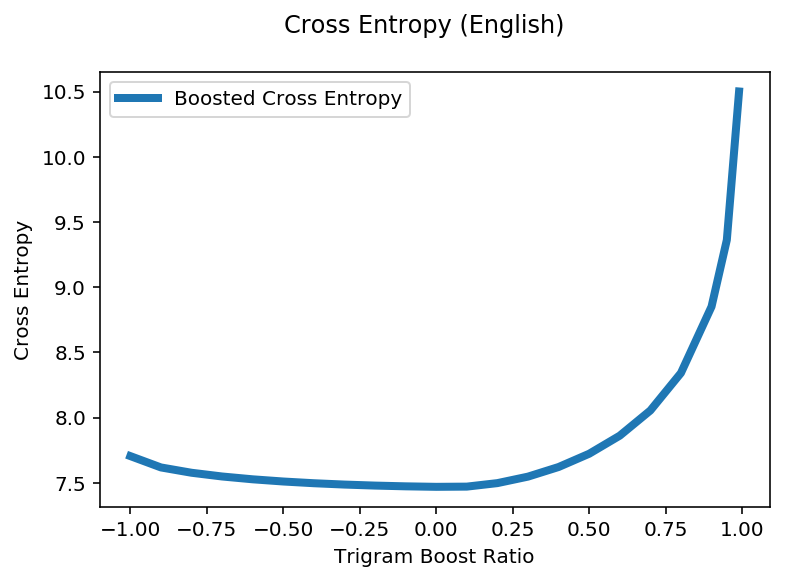

In [167]:
create_lambdas_plot('English', boost_en)

Cross entropy can be thought of intuitively as the average number of bits needed to predict an outcome from a probability distribution given we use another probability distribution to approximate it. If we calculate the cross entropy between our training data and test data as done in this experiment, then we will have a value which will tell us how close our approximation is to the true distribution. The lower the cross entropy, the better. 

The plot above indicates that modifying the trigram lambda parameter will only increase the cross entropy, and therefore worsen the language model's approximation with respect to the test distribution. This means that the trigram lambda is in a (local) minimum. This is as expected, as the EM algorithm is an optimization algorithm that (in this case) finds the optimal lambda weights for each ngram probability function.

The final thing to note is that boosting the trigram lambda results in a much higher cross entropy than discounting it. This is because there are much fewer trigrams in the dataset, so the trigram model is much sparser than the unigram or bigram model. Thus, assigning more probability mass to the trigram model will weaken the entire model significantly. However, reducing the probability mass of the trigram model is also detrimental, as it has some useful information that can improve the language model (just not as much as the unigrams and bigrams).

#### Czech Plot
The graph below plots the cross entropy of the Czech text as a function of the trigram boost ratio. Negative values indicate the amount the trigram parameter was discounted, while positive values indicate how much it was boosted.

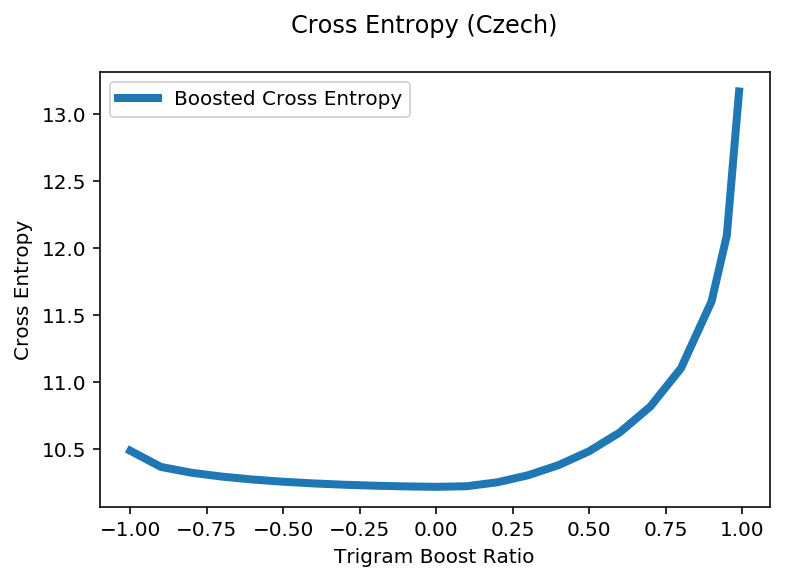

In [111]:
create_lambdas_plot('Czech', boost_cz)

The Czech plot is very similar to the English plot. As in the English plot, the Czech plot indicates that the trigram lambda parameter is (locally) optimal, and that boosting the trigram lambda results in a much higher cross entropy than discounting it.

The only difference is that the Czech language model has a cross entropy that is a few bits higher than English (10.2 vs. 7.5). This can be more easily seen from the last experiment, where it was brought to attention that Czech has a much larger vocabulary due to the many different word affixes that Czech has (declensions, conjugations, etc.). As no stemming or lemmatization was performed, the data will be much more sparse, especially for bigrams and trigrams. Therefore, to observe comparable cross entropy, much more data is needed for the Czech language model.